In [1]:
import datetime

apalis = {
    "alpha": ["/home/tjw/Downloads/apalis/GPS-alpha01.csv", "/home/tjw/Downloads/apalis/GPS-alpha02.csv", "/home/tjw/Downloads/apalis/GPS-zeta01.csv", "/home/tjw/Downloads/apalis/GPS-zeta02.csv", "/home/tjw/Downloads/apalis/GPS-zeta03.csv"],
    "beta": ["/home/tjw/Downloads/apalis/GPS-beta01.csv", "/home/tjw/Downloads/apalis/GPS-eta02.csv"],
    "gamma": ["/home/tjw/Downloads/apalis/GPS-gamma01.csv"],
    "delta": ["/home/tjw/Downloads/apalis/GPS-delta01.csv"],
    #"epsilon": [],
    #"zeta": [],
    #"eta": []
}

gopro = {
    "alpha": ["/home/tjw/Documents/gopro/alpha_json", "/home/tjw/Documents/gopro/zeta_json"],
    "beta": ["/home/tjw/Documents/gopro/beta_json", "/home/tjw/Documents/gopro/eta_json"],
    "gamma": ["/home/tjw/Documents/gopro/gamma_json", "/home/tjw/Documents/gopro/epsilon_json"],
    "delta": ["/home/tjw/Documents/gopro/delta_json"],
    #"epsilon": [],
    #"zeta": [],
    #"eta": []
}

canbus = {
    "apalis1": "/home/tjw/Documents/apalis23/apalis1-DEL_ETA.sql",
    "apalis2g": "/home/tjw/Documents/apalis23/apalis2-GAMMA.sql",
    "apalis2z1": "/home/tjw/Documents/apalis23/apalis2-ZETA1.sql",
    "apalis2z3": "/home/tjw/Documents/apalis23/apalis2-ZETA3.sql",
    "apalis3a": "/home/tjw/Documents/apalis23/apalis3-ALPHA.sql",
   #"apalis3e": "/home/tjw/Documents/apalis23/apalis3-ETA.sql",
    "apalis4a": "/home/tjw/Documents/apalis23/apalis4-ALPHA.sql",
   #"apalis4e": "/home/tjw/Documents/apalis23/apalis4-EPSILON.sql",
   #"apalis5b": "/home/tjw/Documents/apalis23/apalis5-BETA.sql",
    "apalis5z": "/home/tjw/Documents/apalis23/apalis5-ZETA.sql"
}

isoblue = {
    "alpha": { # merged with zeta
        "apalis3a": {"start": datetime.datetime(2023, 5,19),
                     "end":   datetime.datetime(2023, 5,24)},
        "apalis4a": {"start": datetime.datetime(2023, 5,25),
                     "end":   datetime.datetime(2023, 6,16)},
        "apalis2z1":{"start": datetime.datetime(2023, 8,19),
                     "end":   datetime.datetime(2023, 8,30)},
        "apalis5z": {"start": datetime.datetime(2023, 8,30),
                     "end":   datetime.datetime(2023, 9,15)},
        "apalis2z3":{"start": datetime.datetime(2023, 9,15),
                     "end":   datetime.datetime(2023,10,21)}
    },

    "beta": { # merged with eta
        # "apalis5b": {"start": datetime.datetime(2023, 5,25),
        #              "end":   datetime.datetime(2023, 6,23)},
        # "apalis3e": {"start": datetime.datetime(2023, 8,19),
        #              "end":   datetime.datetime(2023, 9,23)},
        "apalis1":  {"start": datetime.datetime(2023, 9,23),
                     "end":   datetime.datetime(2023,10,21)}
    },

    "gamma": { # merged with epsilon
        "apalis2g": {"start": datetime.datetime(2023, 5,25),
                     "end":   datetime.datetime(2023, 6,24)},
        # "apalis4e": {"start": datetime.datetime(2023, 8, 1),
        #              "end":   datetime.datetime(2023,10,21)}
    },

    "delta": { # not merged with any others
        "apalis1": {"start": datetime.datetime(2023, 5,25),
                    "end":   datetime.datetime(2023, 6,16)}
    }
}


maintenance = [ # all the dates of data swaps
    datetime.datetime(2023, 5, 9),
    datetime.datetime(2023, 5,19),
    datetime.datetime(2023, 5,25),
    datetime.datetime(2023, 6,16),
    datetime.datetime(2023, 6,23),
    datetime.datetime(2023, 8,19),
    datetime.datetime(2023, 8,30),
    datetime.datetime(2023, 9,15),
    datetime.datetime(2023, 9,23),
    datetime.datetime(2023,10,20)
]


In [2]:
def stamp(dt):
    # minute = dt.minute - (dt.minute % 10)
    # return f"{dt.date()}_{dt.hour:02}:{minute:02}"
    return f"{dt.date()}_{dt.hour:02}:{dt.minute:02}"

def unstamp(st):
    date, time = st.split("_")
    yy,mm,dd = date.split("-")
    hh,mn = time.split(":")
    #hh,mn = time, 0
    return datetime.datetime(
        year=int(yy), month=int(mm), day=int(dd),
        hour=int(hh), minute=int(mn)
    )

In [3]:
# Read Isoblue GPS data
from dateutil import parser

a_data = {}
SKIP = 5

for tractor in apalis:
    a_data[tractor] = {"datetime":[], "longlat":[], "stamps": [], "speed": {}}
    for csv in apalis[tractor]:
        with open(csv) as file:
            i = 0
            for line in file.readlines()[1:]:
                i += 1
                if i % SKIP == 0:
                    # Parse data from CSV
                    time, lat, lng = line.split(",")
                    lat = float(lat)
                    lng = float(lng.rstrip())
                    time = parser.isoparse(time)
                    
                    # Add data to dict
                    a_data[tractor]["datetime"].append(time)
                    a_data[tractor]["longlat"].append((lng, lat))
                    st = stamp(time)
                    
                    if st not in a_data[tractor]["stamps"]:
                        a_data[tractor]["stamps"].append(st)


In [4]:
# Get line totals for DB dumps
import subprocess

line_total = {}

for db in canbus:
    line_total[db] = int(subprocess.check_output(["wc", "-l", canbus[db]]).decode().split()[0])


In [5]:
def roll_avg(frame, new):
    N = frame[1] + 1
    output = frame[0]*(1 - 1/N) + new/N
    return output, N


In [6]:
# Read Isoblue CAN data
import time
#MAGIC = 0.00125 # scaling factor for CAN bus ground speed to get (kph?)
MAGIC = 0.0025
BAR_W = 49

c_data = {}

for tractor in isoblue:
    c_data[tractor] = {"speed":{}, "stamps":[]}

    for db in isoblue[tractor]:
        stime = time.time()
        start = isoblue[tractor][db]["start"]
        end = isoblue[tractor][db]["end"]

        with open(canbus[db]) as file:
            i = 0
            for line in file:
                if "can0" in line:
                    l = line.split("\t")
                    arb = l[2]
                    if arb[2:6] == "FEF1": # vehicle ground speed PGN
                        
                        # Get datetime of line
                        timestamp = l[0].split(".")[0]
                        if "+" in timestamp:
                            timestamp = timestamp.split("+")[0]
                        dt = parser.isoparse(timestamp)
                        
                        # Check that line is within parameters of tractor
                        if dt >= start and dt < end:
                            hex_data = l[3]
                            speed = MAGIC * (256*int(hex_data[4:6], 16) + 
                                             int(hex_data[6:8], 16))
                            
                            # Save data to output
                            st = stamp(dt)
                            if st not in c_data[tractor]["speed"].keys():
                                c_data[tractor]["speed"][st] = (speed, 1)
                            else:
                                c_data[tractor]["speed"][st] = roll_avg(
                                    c_data[tractor]["speed"][st], speed
                                )
                            
                            if st not in c_data[tractor]["stamps"]:
                                c_data[tractor]["stamps"].append(st)
            
                # Print progress
                i += 1
                if i % 250_000 == 0:
                    y = time.time() - stime
                    x = i/line_total[db]
                    pct = round(BAR_W*x)
                    bar = "="*pct
                    space = " "*(BAR_W-pct)
                    print(f"[{tractor}/{db}]: |{bar}>{space}| ~{round((y/x)-y)}s remain...   ", end="\r")
        print(f"[{tractor}/{db}] Finished with {db} in {round(time.time() - stime)}s {' '*BAR_W}")
    print(f"**[{tractor}] Found a total of {len(c_data[tractor]['speed'])} speeds")


[alpha/apalis3a] Finished with apalis3a in 12s                                                  
[alpha/apalis4a] Finished with apalis4a in 235s                                                  
[alpha/apalis2z1] Finished with apalis2z1 in 0s                                                  
[alpha/apalis5z] Finished with apalis5z in 235s                                                  
[alpha/apalis2z3] Finished with apalis2z3 in 52s                                                  
**[alpha] Found a total of 12809 speeds
[beta/apalis1] Finished with apalis1 in 92s                                                  
**[beta] Found a total of 3463 speeds
[gamma/apalis2g] Finished with apalis2g in 13s                                                  
**[gamma] Found a total of 759 speeds
[delta/apalis1] Finished with apalis1 in 65s                                                  
**[delta] Found a total of 729 speeds


In [7]:
def goproParse(jsondata):
    gps = []
    times = []
    stamps = []
    for frame in jsondata:
        time = parser.isoparse(frame["gps_time"])
        if time.year == 2023:
            times.append(time)
            stamps.append(stamp(time))
            lon = frame["cam_gps"]["lon"]
            lat = frame["cam_gps"]["lat"]
            gps.append((lon,lat))
    return (times, gps, stamps)

In [8]:
import json, os
g_data = {}
for tractor in gopro:
    g_data[tractor] = {"datetime":[], "longlat":[], "stamps":[]}
    for folder in gopro[tractor]:
        for file in os.listdir(folder):
            if "metadata" not in file:
                with open(os.path.join(folder, file)) as file:
                    times, gps, stamps = goproParse(json.load(file))
                    g_data[tractor]["longlat"] += (gps)
                    g_data[tractor]["datetime"] += times

                    for st in stamps:
                        if st not in g_data[tractor]["stamps"]:
                            g_data[tractor]["stamps"].append(st)


In [9]:
def same(x1, x2): # return intersection of two lists
    output = []
    for x in x1:
        if x in x2:
            output.append(x)
    return output

def inany(x1, x2): # return union of two lists
    output = [x for x in x1]
    for x in x2:
        if x not in output:
            output.append(x)
    return output


In [10]:
tractors = same(gopro, apalis)

print(tractors)

['alpha', 'beta', 'gamma', 'delta']


In [11]:
u_data = {}

for tractor in tractors:
    u_data[tractor] = {}
    u_data[tractor]["stamps"] = same(a_data[tractor]["stamps"], g_data[tractor]["stamps"])
    u_data[tractor]["longlat"] = []

    for i in range(0, len(g_data[tractor]["datetime"]), SKIP):
        if stamp(g_data[tractor]["datetime"][i]) in u_data[tractor]["stamps"]:
            u_data[tractor]["longlat"].append(g_data[tractor]["longlat"][i])


In [9]:
import geojson
from shapely.geometry import Polygon

with open("County_Boundaries_of_Indiana_2023.geojson") as file:
    IN_COUNTIES = geojson.load(file)

counties = {}
for i in range(len(IN_COUNTIES["features"])):
    name = IN_COUNTIES["features"][i]["properties"]["name"]
    name = name.split(" County")[0]
    counties[name] = Polygon(IN_COUNTIES["features"][i]["geometry"]["coordinates"][0][0])


In [10]:
# Copied from https://stackoverflow.com/a/70533052
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

In [11]:
from shapely.geometry import Point

# Greedy (but still slow) County Checker
def check_county(coords, county):
    for point in coords:
        if county.contains(Point(point)):
            return True
    return False

# Greedy tractor-county checker
def tc_check(dataset, county):
    for tractor in dataset:
        if check_county(dataset[tractor]["longlat"], county):
            return True
    return False


In [12]:
# Check which counties had which/both sources
data_counties = {}
for county in counties:
    data_counties[county] = ""
    if tc_check(u_data, counties[county]):
        data_counties[county] = "Both"
    else:
        if tc_check(a_data, counties[county]):
            data_counties[county] += "A"
        if tc_check(g_data, counties[county]):
            data_counties[county] += "G"
    
    print(f"{county}: {data_counties[county]}")


Adams: Both
Allen: Both
Blackford: Both
Boone: A
Brown: G
Carroll: 
Clark: G
Daviess: A
Dekalb: G
Delaware: AG
Dubois: A
Elkhart: G
Fayette: G
Fountain: 
Franklin: Both
Fulton: Both
Gibson: 
Greene: A
Hamilton: Both
Hancock: 
Henry: G
Jackson: Both
Jasper: Both
Jefferson: G
Jennings: Both
Knox: 
Kosciusko: Both
Lake: Both
Laporte: AG
Madison: Both
Marion: Both
Montgomery: 
Newton: Both
Noble: Both
Ohio: 
Owen: 
Parke: 
Perry: 
Pike: 
Porter: Both
Posey: 
Pulaski: AG
Putnam: 
Randolph: AG
Ripley: 
Rush: G
St Joseph: AG
Scott: G
Shelby: 
Spencer: 
Starke: AG
Sullivan: 
Switzerland: 
Tippecanoe: 
Tipton: AG
Union: 
Vanderburgh: 
Vermillion: 
Vigo: 
Warren: G
Warrick: Both
Washington: A
Wayne: 
Bartholomew: 
Benton: G
Cass: AG
Clay: 
Crawford: A
Clinton: 
Dearborn: 
Decatur: Both
Floyd: 
Grant: Both
Hendricks: 
Harrison: 
Howard: Both
Huntington: Both
Johnson: AG
Jay: Both
Lagrange: G
Lawrence: Both
Miami: Both
Monroe: AG
Morgan: A
Martin: Both
Marshall: Both
Orange: Both
Steuben: AG
Wabas

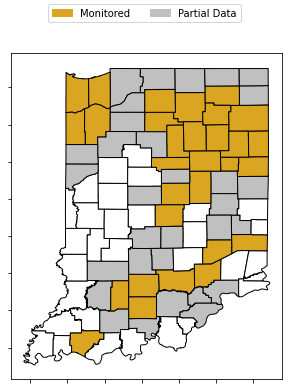

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as pch

fig, ax = plt.subplots()
for county in counties:
    if data_counties[county] == "Both":
        plot_polygon(ax, counties[county], facecolor="goldenrod", edgecolor="black")
    elif data_counties[county] in ["A", "G", "AG"]:
        plot_polygon(ax, counties[county], facecolor="silver", edgecolor="black")
    else:
        plot_polygon(ax, counties[county], facecolor="white", edgecolor="black")

# Create legend
gold = pch.Patch(color="goldenrod", label="Full Record")
silver = pch.Patch(color="silver", label="Partial Record")
fig.legend([gold, silver], ["Monitored", "Partial Data"], loc="upper center", ncol=2)

ax.set_xticklabels("")
ax.set_yticklabels("")
fig.set_size_inches(6,6)
ax.set_aspect(1.0)


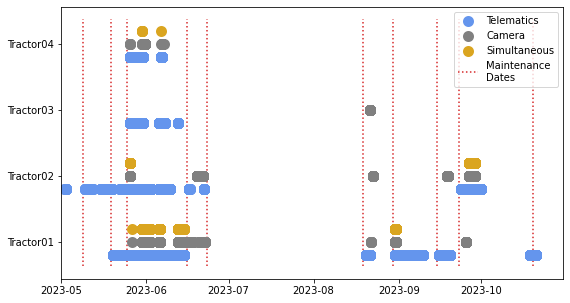

In [18]:
import matplotlib.pyplot as plt
x= {}
fig = plt.figure()

i = 0
for tractor in tractors:
    # IsoBlue Data
    x[tractor] = [unstamp(date) for date in a_data[tractor]["stamps"]]
    blue = plt.scatter(x[tractor], [i-0.2 for _ in x[tractor]], color="cornflowerblue", linewidths=5, label="Telematics")

    # GoPro Data
    x[tractor] = [unstamp(date) for date in g_data[tractor]["stamps"]]
    grey = plt.scatter(x[tractor], [i for _ in x[tractor]], color="grey", linewidths=5, label="Camera")

    # Both data
    x[tractor] = [unstamp(date) for date in u_data[tractor]["stamps"]]
    gold = plt.scatter(x[tractor], [i+0.2 for _ in x[tractor]], color="goldenrod", linewidths=5, label="Both")

    i += 1

bot, top = plt.ylim()
red = plt.vlines(maintenance, ymin=bot, ymax=top, colors="tab:red", linestyles="dotted", zorder=0)

plt.legend([blue, grey, gold, red], ["Telematics", "Camera", "Simultaneous", "Maintenance\nDates"])
inum = [i for i in range(len(x))]
plt.yticks(ticks=inum, labels=[f"Tractor{i+1:02}" for i in inum])
fig.set_size_inches(9,5)
plt.xlim(datetime(2023, 5, 1), datetime(2023, 10, 31))
plt.show()

In [14]:
minutes = {
    "Telematics-Only": 0,
    "Camera-Only": 0,
    "Both": 0
}
MIN_SPEED = 2 # cutoff for ground speed needed to say they were actually working
nm = 0

for tractor in tractors:
    for st in inany(a_data[tractor]["stamps"], g_data[tractor]["stamps"]):
        if st in u_data[tractor]["stamps"]:
            if st not in c_data[tractor]["speed"]:
                minutes["Both"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Both"] += 1
            else:
                nm += 1
        elif st in a_data[tractor]["stamps"]:
            if st not in c_data[tractor]["speed"]:
                minutes["Telematics-Only"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Telematics-Only"] += 1
            else:
                nm += 1
        else:
            if st not in c_data[tractor]["speed"]:
                minutes["Camera-Only"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Camera-Only"] += 1
            else:
                nm += 1

print(f"CAN ground speed prevented counting {round(nm/60, 1)} hours of data")
minutes


CAN ground speed prevented counting 33.7 hours of data


{'Telematics-Only': 85533, 'Camera-Only': 3875, 'Both': 1670}

In [17]:
hours = {
    "Telematics-Only": minutes["Telematics-Only"]/60,
    "Camera-Only": minutes["Camera-Only"]/60,
    "Simultaneous": minutes["Both"]/60
}

hours


{'Telematics-Only': 1425.55,
 'Camera-Only': 64.58333333333333,
 'Simultaneous': 27.833333333333332}